In [0]:
import requests
import json

In [0]:
#I chose Alexander Torrenegra because he is the most popular person on the platform. He has a great source of user recommendation data
username = "torrenegra"
#Let's not limit degrees of separation to less than 6 because we want to analyze as much data as possible
limit = 6
#Let's call the API for analyzing profile's connections
url = ("https://torre.bio/api/people/%s/network?[deep=%s]" % (username, limit))
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
response = requests.get(url, headers = headers)

In [0]:
#Parse the JSON object only filtering the publicId (for filtering use later on) and the weight of the profile's connections
people_by_connection = response.json()["graph"]["nodes"]
all_ids = {}

for people in people_by_connection:
  try:
    all_ids[people["metadata"]["publicId"]] = people["metadata"]["weight"]
  except:
    pass

In [0]:
#Remove extreme outliers considering users with 0 or 20,000 in weight
non_zero_users = { k: all_ids[k] for k,v in all_ids.items() if v >= 2}

scores = list(non_zero_users.values())
scores.remove(max(scores))

NameError: ignored

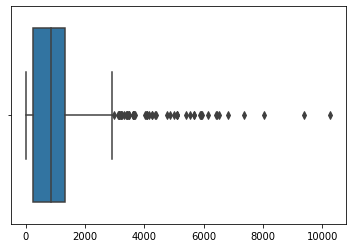

In [0]:
#Visual representation of Q1, average, Q3, min, max
import seaborn as sns
sns.boxplot(scores)
plt.show()

In [133]:
# calculate a 5-number summary
from numpy import percentile
from numpy.random import rand
# calculate quartiles
quartiles = percentile(scores, [25, 50, 75, 90, 95, 99])
# calculate min/max
score_min, score_max = min(scores), max(scores)
# print 5-number summary
print('Min: %.3f' % score_min)
print('Q1: %.3f' % quartiles[0])
print('Median: %.3f' % quartiles[1])
print('Q3: %.3f' % quartiles[2])
print('90 percentile: %.3f' % quartiles[3])
print('95 percentile: %.3f' % quartiles[4])
print('99 percentile: %.3f' % quartiles[5])
print('Max: %.3f' % score_max)

Min: 2.070
Q1: 224.033
Median: 851.047
Q3: 1316.935
90 percentile: 2551.047
95 percentile: 3620.460
99 percentile: 6369.716
Max: 10264.679


In [0]:
#Filter all users below 90 percentile
top_90_users = { k: all_ids[k] for k,v in all_ids.items() if v >= quartiles[3] }

In [136]:
#Count how many users meet our criteria
userIDs = list(top_90_users)
print(len(userIDs))

75


In [0]:
#Extract profile data from Torre API waiting between 1 and 2 seconds per call  
import time, random
features_top_90_users = []
for userID in userIDs:
  url2 = ("https://torre.bio/api/bios/%s" % (userID))
  response2 = requests.get(url2, headers=headers)
  features_top_90_users.append(response2)
  time.sleep(random.randint(1,2))

In [0]:
#Extract all relevant features from users, including numbers and booleans. With more time we can explore using NLTK for strings.
user_and_features = {}

for user in features_top_90_users:
  tmp_dict = {}
  name = user.json()["person"]["name"]
  for feature in user.json().keys():
    try:
      for subfeature in user.json()[feature].keys():
          results = (user.json()[feature][subfeature])
          if isinstance(results,float) or isinstance(results,bool) or isinstance(results,int):
            tmp_dict[subfeature] = results
    except:
      pass
  user_and_features[name] = tmp_dict

In [0]:
#Our last code doesn't explore DFS, only the first two entries. This code will help us later to extract all features possible
def iterdict(d):
  for k,v in d.items():        
     if isinstance(v, dict):
         iterdict(v)
     else:            
         print (k,":",v)

In [140]:
#Not every user has the same features, therefore we first want to see which features are more common in Torre profiles
repeated_features = []

for name2 in user_and_features:
  for features2 in user_and_features[name2]:
    repeated_features.append(features2)

unique_features = list(set(repeated_features))
incomplete_features = []

for unique in unique_features:
  incomplete_features.append(unique)
  print({unique: repeated_features.count(unique)})
    

{'weight': 75}
{'publications': 11}
{'hasEmail': 75}
{'verified': 75}
{'showPhone': 75}
{'completion': 75}
{'education': 61}
{'achievements': 39}
{'interests': 49}
{'claimant': 75}
{'projects': 36}
{'strengths': 75}
{'jobs': 70}


In [0]:
#Fill up missing features using 0s
for k3,v3 in user_and_features.items():
  for incomplete in incomplete_features:
    if incomplete not in v3:
      user_and_features[k3][incomplete] = 0


In [142]:
#Make sure all users include the same features altough some features are filled with zeros. 
#THE PURPOSE OF THIS IS TO CORRECTLY FORMAT THE DATA FOR LATER USE IN A DEEP LEARNING ALGORITHM

repeated_features = []

for name2 in user_and_features:
  for features2 in user_and_features[name2]:
    repeated_features.append(features2)

unique_features = list(set(repeated_features))
incomplete_features = []

for unique in unique_features:
  print({unique: repeated_features.count(unique)})
    

{'weight': 75}
{'publications': 75}
{'hasEmail': 75}
{'verified': 75}
{'showPhone': 75}
{'completion': 75}
{'education': 75}
{'achievements': 75}
{'interests': 75}
{'claimant': 75}
{'projects': 75}
{'strengths': 75}
{'jobs': 75}


In [146]:
#Let's take a look at how our data looks at first
import pandas as pd
df = pd.DataFrame(user_and_features)
df = df.transpose()

#Convert our data from boolean to binary
df*1

df.head(5)

,completion,showPhone,verified,weight,hasEmail,claimant,strengths,education,interests,jobs,projects,achievements,publications
Beto Saavedra,1,False,True,3619.14,True,True,21,1,3,11,5,1,0
Mauricio Robles,0.9231,True,True,2710.82,True,True,18,7,3,8,0,5,8
Alexander Torrenegra,1,False,True,19758.2,True,True,23,5,5,10,10,7,11
Alvaro Andres Salom D Luyz,1,False,True,4854.28,True,True,81,3,3,7,0,3,0
Daniela Avila Gomez,1,False,True,9395.08,True,True,23,4,5,8,25,6,0


,completion,showPhone,verified,weight,hasEmail,claimant,strengths,education,interests,jobs,projects,achievements,publications
Beto Saavedra,1,0,1,3619.14,1,1,21,1,3,11,5,1,0
Mauricio Robles,0.9231,1,1,2710.82,1,1,18,7,3,8,0,5,8
Alexander Torrenegra,1,0,1,19758.2,1,1,23,5,5,10,10,7,11
Alvaro Andres Salom D Luyz,1,0,1,4854.28,1,1,81,3,3,7,0,3,0
Daniela Avila Gomez,1,0,1,9395.08,1,1,23,4,5,8,25,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Brian Requarth,0.3077,1,1,6518.16,1,1,2,0,0,0,0,1,0
Daniella Gonzalez Rubio,0.8462,1,1,6408.93,1,1,9,6,3,3,0,1,0
Andrés Felipe Cajiao,0.3846,1,1,2872.59,1,1,9,0,0,0,0,0,0
Patrick McGinnis,0.5385,1,1,5668.16,1,1,4,4,0,16,4,0,2
